<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 1:

* In this notebook, we will build a `DNN` model for classifying MNIST digits. The `DNN` model will consist of 784 input nodes, a hidden layer with 128 nodes and 10 output nodes (corresponding to the 10 digits). 
* We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. 
* After training and evaluating our `DNN` model we analyze its performance. In particular, we use confusion matrices to compare the `predicted classes` with the `class labels` to try to determine why some images were misclassified by the model.
* We then obtain the 60,000 `activation values` of one of the hidden nodes for the (original) set of training data. We want to use these `activation values` as "proxies" for the predicted classes of the 60,000 images. 
* And just like we compared the `predicted classes` with the `class labels` using confusion matrices to determine the efficacy of the model, we use `box plots` to visualize the relationship between the `activation values` of one hidden node and the `class labels`. We don't expect these activation values to have much "predictive power". In fact, the same activation values can be associated with multiple class labels resulting in a lot of overlap in the `box plots`.
* We also perform similar experiments comparing the values at two pixel locations in the images with the class labels. This time we use `scatter plots` to visualize the relationship between the pair of pixel values with the class labels (represented by different colored dots).
* Pixel values at two locations in image should not have much predictive value. To improve on this approach, we the PCA decomposition on both the raw data of 784 pixel values and 128 hidden node activation values to reduce the number of features to 2 in each case. Once again, we use a `scatter plot` to visualize the correlation between the two principal component values and the class labels.
*  Finally, we use a Random Forest Classifier to find the relative importance of the 784 features (pixels) in the training set. We then select the 70 most important feature (pixels) from the training, validation and test images to test our 'best' model on.

## 1. Importing Packages 

* First we import all the packages that will be used in the assignment.

* Since Keras is integrated in TensorFlow 2.x, we import `keras` from `tensorflow` and use `tenserflow.keras.xxx` to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [ ]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
#from plot_keras_history import plot_history

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True) 

### Verify TensorFlow version and Keras version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.6.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.6.0


### Mount Google Drive to Colab environment

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### Functions For Research Assignment 

In [ ]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## 2. Loading MNIST Dataset

* The MNIST dataset of handwritten digits has a training set of 60,000 images, and a test set of 10,000 images. It comes prepackaged as part of `tf.Keras`. Use the `tf.keras.datasets.mnist.load_data` to the get these datasets (and the corresponding labels) as Numpy arrays.

In [ ]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


* Tuples of Numpy arrays: `(x_train, y_train)`, `(x_test, y_test)`
* `x_train`, `x_test`: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
* `y_train`, `y_test`: uint8 arrays of digit labels (integers in range 0-9)

## 3. EDA Training and Test Sets

* Inspect the training and test sets as well as their labels as follows.

In [ ]:
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)


### Review labels for training set

In [ ]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [5 0 4 1 9 2 1 3 1 4]



### Find frequency of each label in training and test sets

In [ ]:
Counter(y_train).most_common()

[(1, 6742),
 (7, 6265),
 (3, 6131),
 (2, 5958),
 (9, 5949),
 (0, 5923),
 (6, 5918),
 (8, 5851),
 (4, 5842),
 (5, 5421)]

In [ ]:
Counter(y_test).most_common()

[(1, 1135),
 (2, 1032),
 (7, 1028),
 (3, 1010),
 (9, 1009),
 (4, 982),
 (0, 980),
 (8, 974),
 (6, 958),
 (5, 892)]

### Plot sample images with their labels

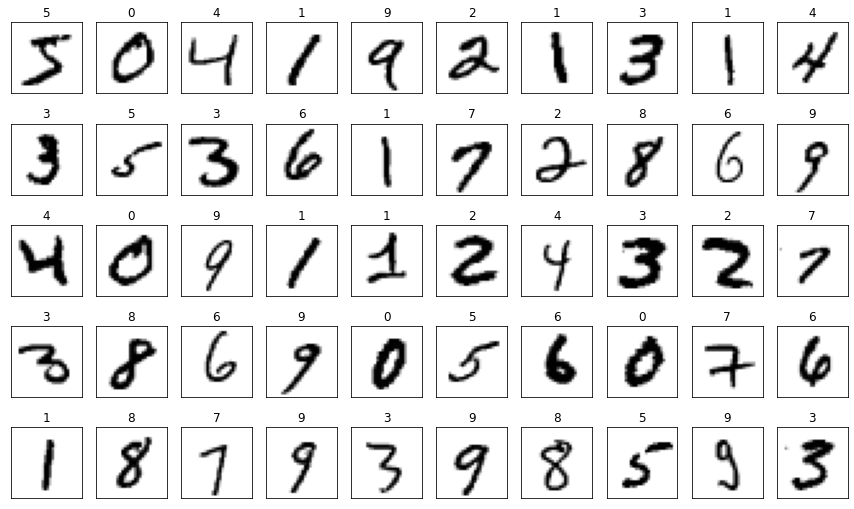

In [ ]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

## 4. Preprocessing Data

* Before we build our model, we need to prepare the data into the shape the network expected
* More specifically, we will convert the labels (integers 0 to 9) to 1D numpy arrays of shape (10,) with elements 0s and 1s. 
* We also reshape the images from 2D arrays of shape (28,28) to 1D *float32* arrays of shape (784,) and then rescale their elements to values between 0 and 1.

### Apply one-hot encoding on the labels

We will change the way the labels are represented from numbers (0 to 9) to vectors (1D arrays) of shape (10, ) with all the elements set to 0 except the one which the label belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 5 | [0 0 0 0 0 1 0 0 0 0] |
| 7 | [0 0 0 0 0 0 0 1 0 0] |
| 1 | [0 1 0 0 0 0 0 0 0 0] |

In [ ]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))

First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [ ]:
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)


### Reshape the images to 1D arrays

Reshape the images from shape (28, 28) 2D arrays to shape (784, ) vectors (1D arrays).

In [ ]:
# Before reshape:
print('x_train:\t{}'.format(x_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))

x_train:	(60000, 28, 28)
x_test:		(10000, 28, 28)


In [ ]:
np.set_printoptions(linewidth=np.inf)
print("{}".format(x_train[2020]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 167 208  19   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  13 235 254  99   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  74 254 234   4   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 154 254 145   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 224 254  92   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  51 245 211  13   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2 169 254 101   0   0   0   0   0   

In [ ]:
# Reshape the images:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

# After reshape:
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


1. Each element in an image is a pixel value
2. Pixel values range from 0 to 255
3. 0 = White
4. 255 = Black

### Review unique values with set from 1st image

In [ ]:
print(set(x_train_reshaped[0]))

{0, 1, 2, 3, 9, 11, 14, 16, 18, 23, 24, 25, 26, 27, 30, 35, 36, 39, 43, 45, 46, 49, 55, 56, 64, 66, 70, 78, 80, 81, 82, 90, 93, 94, 107, 108, 114, 119, 126, 127, 130, 132, 133, 135, 136, 139, 148, 150, 154, 156, 160, 166, 170, 171, 172, 175, 182, 183, 186, 187, 190, 195, 198, 201, 205, 207, 212, 213, 219, 221, 225, 226, 229, 238, 240, 241, 242, 244, 247, 249, 250, 251, 252, 253, 255}


### Rescale the elements of the reshaped images

Rescale the elements between [0 and 1]

In [ ]:
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

In [ ]:
# Take a look at the first reshaped and normalized training image:
print(set(x_train_norm[0]))

{0.0, 0.011764706, 0.53333336, 0.07058824, 0.49411765, 0.6862745, 0.101960786, 0.6509804, 1.0, 0.96862745, 0.49803922, 0.11764706, 0.14117648, 0.36862746, 0.6039216, 0.6666667, 0.043137256, 0.05490196, 0.03529412, 0.85882354, 0.7764706, 0.7137255, 0.94509804, 0.3137255, 0.6117647, 0.41960785, 0.25882354, 0.32156864, 0.21960784, 0.8039216, 0.8666667, 0.8980392, 0.7882353, 0.52156866, 0.18039216, 0.30588236, 0.44705883, 0.3529412, 0.15294118, 0.6745098, 0.88235295, 0.99215686, 0.9490196, 0.7647059, 0.2509804, 0.19215687, 0.93333334, 0.9843137, 0.74509805, 0.7294118, 0.5882353, 0.50980395, 0.8862745, 0.105882354, 0.09019608, 0.16862746, 0.13725491, 0.21568628, 0.46666667, 0.3647059, 0.27450982, 0.8352941, 0.7176471, 0.5803922, 0.8117647, 0.9764706, 0.98039216, 0.73333335, 0.42352942, 0.003921569, 0.54509807, 0.67058825, 0.5294118, 0.007843138, 0.31764707, 0.0627451, 0.09411765, 0.627451, 0.9411765, 0.9882353, 0.95686275, 0.83137256, 0.5176471, 0.09803922, 0.1764706}


## 5. Creating the DNN Model

* In this step, we first choose the network architecture for the model. Then we build.compile, train and evaulate the model.

### Specify the network architecture

Below is the neural network architecture we will use today for classifying MNIST digits.

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/DNN_architecture.png?raw=1">

### Build the DNN model

We use a `Sequential` class defined in `Keras` to create our model. All the layers are going to be Dense layers. This means, like the figure shown above, all the nodes of a layer would be connected to all the nodes of the preceding layer i.e. densely connected.

After the model is built, we view ....

In [ ]:
model = Sequential([
    Dense(input_shape=[784], units=512, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
output_layer (Dense)         (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


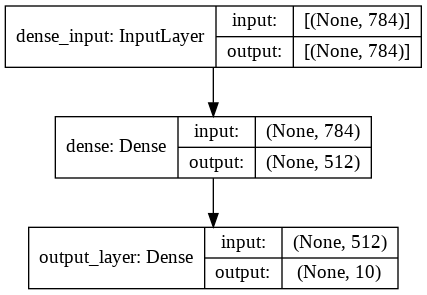

In [ ]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

### Compile the DNN model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimized in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimizes the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.


<b>tf.keras.optimizers.RMSprop</b><br> 
 https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop


<b>tf.keras.losses.CategoricalCrossentropy</b><br> 
  https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy


In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

### Train the DNN model

<b>tf.keras.model.fit</b><br>
  https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
history = model.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20 
    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)] 
    )

Epoch 1/200
1500/1500 [==============================] - 5s 2ms/step - loss: 0.4116 - accuracy: 0.9241 - val_loss: 0.2690 - val_accuracy: 0.9490
Epoch 2/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2388 - accuracy: 0.9537 - val_loss: 0.2263 - val_accuracy: 0.9556
Epoch 3/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2126 - accuracy: 0.9593 - val_loss: 0.2567 - val_accuracy: 0.9458
Epoch 4/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2002 - accuracy: 0.9620 - val_loss: 0.1850 - val_accuracy: 0.9643
Epoch 5/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1915 - accuracy: 0.9628 - val_loss: 0.1770 - val_accuracy: 0.9674
Epoch 6/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1836 - accuracy: 0.9644 - val_loss: 0.2140 - val_accuracy: 0.9557
Epoch 7/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1796 - accuracy: 0.9654 - val_loss: 0.1755 - val_ac

### Evaluate the DNN model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 2ms/step - loss: 0.1493 - accuracy: 0.9722
test set accuracy:  97.21999764442444


## 6. Making Predictions

In [ ]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


Look at the first 25 - Plot test set images along with their predicted and actual labels to understand how the trained model actually performed

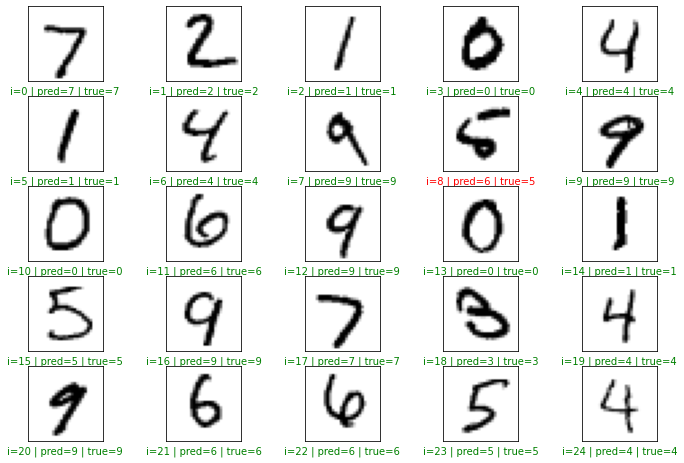

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

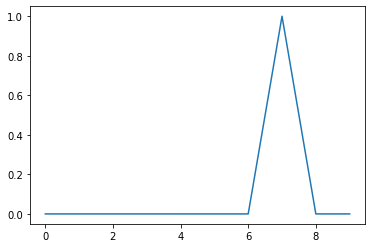

In [ ]:
"""
Enter the index value in place of the value 17 below for the prediction
that you want to plot the probability scores for
"""
index = 17

plt.plot(preds[index])
plt.show()

## 7. Reviewing Performance

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Plot performance metrics 

We use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

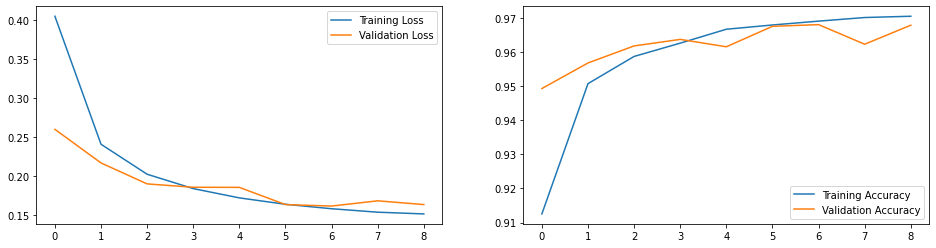

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.96      0.97      1032
           3       0.99      0.95      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.97      0.97      0.97       892
           6       0.97      0.97      0.97       958
           7       0.94      0.99      0.96      1028
           8       0.97      0.95      0.96       974
           9       0.99      0.94      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy Score: 0.9692
Root Mean Square Error: 0.7785884663928692


### Create the confusion matrix

Let us see what the confusion matrix looks like. Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9
0,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%,0.00%
1,0.00%,0.01%,99.94%,0.05%,0.00%,0.00%,0.01%,0.00%,0.00%,0.00%
2,0.00%,98.43%,0.16%,0.02%,0.13%,0.05%,0.11%,0.59%,0.51%,0.01%
3,99.99%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,0.01%,0.00%,0.00%
4,0.00%,0.00%,0.00%,0.00%,99.59%,0.00%,0.00%,0.31%,0.00%,0.10%
5,0.00%,98.12%,0.01%,0.00%,0.09%,0.00%,0.00%,1.70%,0.08%,0.00%
6,0.00%,0.00%,0.00%,0.00%,99.90%,0.00%,0.00%,0.02%,0.05%,0.02%
7,0.00%,0.00%,0.03%,0.13%,1.50%,0.01%,0.00%,0.04%,0.03%,98.27%
8,0.02%,0.00%,1.09%,0.00%,0.25%,20.98%,75.48%,0.00%,2.13%,0.06%
9,0.00%,0.00%,0.00%,0.00%,0.37%,0.00%,0.00%,0.83%,0.01%,98.78%


### Visualize the confusion matrix

We use code from chapter 3 of Hands on Machine Learning (A. Geron) (cf. https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb) to display a "heat map" of the confusion matrix. Then we normalize the confusion matrix so we can compare error rates. 

See https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch03.html#classification_chapter

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

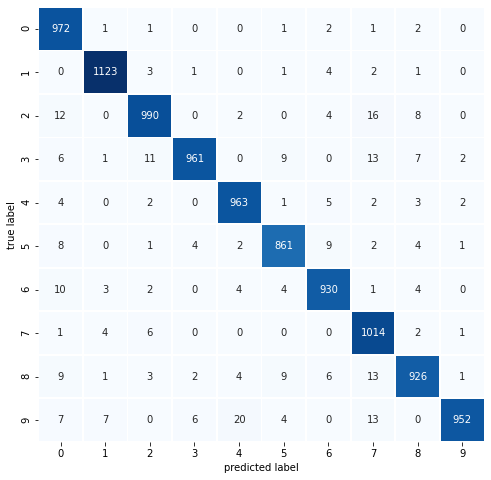

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

The confusion matrix looks quite good!

Looks like 28 fours were misclassified as nines (and 10 nines were classifed fours). We display some of these misclassfications along with exam of fours and nines that were correctly identified.